## Analysis of the full glycolysis network - Fructose substrate
#### Experiment code : SNMS34

In [1]:
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import seaborn as sns; sns.set_theme(style='ticks', context='paper')
import colorcet as cc
import glob

import toml

In [2]:
#Definition of constants
TIMEBIN = 90 #Binning (~45s)

### Isotopic ratios for isotopic correction (15N-Glu, NADH) ###
Glu_13C_isotope = 0.0546 # Percentage of signal of glutamate isotope (146) to remove from 15N-glutamate (147)
NAD_2_13C_isotope = 0.0245 # Percentage of signal of NAD isotope (662) to remove from NADH (664)
Glu_conc_ratio = 0.104429302 #Ratio of concentrations of glutamate (0.05517 mM) and 15N-glutamate (0.5283 mM)


### NMR concentrations ###
F_concentration = 0.09288 # mM
G_concentration = 0.07956 # mM
G6P_concentration = 0.08957 # mM
F6P_concentration = 0.07707 # mM
FBP_concentration = 0.05594 # mM
ATP_concentration = 0.05 # mM
Pyr_concentration = 0.0912 # mM
Lac_concentration = 0.096288 # mM
PG_concentration = 0.088709 # mM
PEP_concentration = 0.09325 # mM

### Frag ratios ###
FBPtoF6P = 0.071
FtoLac = 0.058
GtoLac = 0.038

## Reading the data and conditions

In [3]:
#Reading the conditions
flow_parameters = toml.load("conditions/SNMS34_flowparameters.toml")
inputs = np.array([[c['length'], c['syringe_parameters']['F']['reactor_concentration'], 
                    c['syringe_parameters']['ATP']['reactor_concentration'], 
                    c['syringe_parameters']['ADP']['reactor_concentration'], 
                    c['syringe_parameters']['NAD']['reactor_concentration']] 
                    for c in flow_parameters['sections']
                ])

df_inputs = pd.DataFrame(
        inputs, columns=['time', 'F', 'ATP', 'ADP', 'NAD']
    ).assign(time = np.cumsum(inputs[:,0]))
print(df_inputs)
#correcting the inputs for time in minutes
df_inputgraph = df_inputs.copy()
df_inputgraph['time'] = (df_inputs['time'] / 60) - 60 #in minutes, minus the first 60 minutes of equilibration

       time     F   ATP   ADP  NAD
0    1800.0  4.50  1.50  1.50  1.5
1    7000.0  4.50  2.25  0.75  1.5
2   10600.0  3.00  2.25  0.75  1.5
3   14200.0  1.50  2.25  0.75  1.5
4   17800.0  0.75  2.25  0.75  1.5
5   21400.0  4.50  0.75  2.25  1.5
6   25000.0  3.00  0.75  2.25  1.5
7   28600.0  1.50  0.75  2.25  1.5
8   32200.0  0.75  0.75  2.25  1.5
9   35800.0  4.50  2.25  0.75  1.0
10  39400.0  3.00  2.25  0.75  1.0
11  43000.0  1.50  2.25  0.75  1.0
12  46600.0  0.75  2.25  0.75  1.0
13  50200.0  4.50  0.75  2.25  1.0
14  53800.0  3.00  0.75  2.25  1.0
15  57400.0  1.50  0.75  2.25  1.0
16  61000.0  0.75  0.75  2.25  1.0


In [4]:
#Reading the data
files = pathlib.Path(f"data/SNMS34/").glob('*.xy')

sumdf = pd.DataFrame()
    
try:
    with open(f"data/SNMS34/TIC.xy",'r') as fin:
        df = pd.read_csv(fin, sep=' ', names=['Time','TIC'])
        df_TICSamp1 = df['Time'].groupby(df.index // TIMEBIN).min()
        df_TICSamp2 = df['TIC'].groupby(df.index // TIMEBIN).sum()
        df_TICSamp = pd.concat([df_TICSamp1,df_TICSamp2], axis=1)
                    
except FileNotFoundError:
    print("No TIC files here!")
    
df_Time = df_TICSamp['Time']

sumdf["retention_time"] = df_Time
        
fileList=glob.glob(f"data/SNMS34/*.xy")
fileList.remove(f"data/SNMS34\\TIC.xy")
    
for file in fileList:
    try:
        with open(file,'r') as fin:
            df_file = pd.read_csv(fin, sep=' ', names=['Time','IC'])

            ionname = pathlib.Path(file).stem
            
            #binning
            df_Samp1 = df_file['Time'].groupby(df_file.index // TIMEBIN).min()
            df_Samp2 = df_file['IC'].groupby(df_file.index // TIMEBIN).sum()
            df_Samp = pd.concat([df_Samp1,df_Samp2], axis=1)

            #TIC corr
            df_SampTIC = df_Samp['IC'] / df_TICSamp['TIC']
            df_SampTIC.name = ionname

            sumdf[ionname] = df_SampTIC
    except FileNotFoundError:
        print("Missing files")

    
sumdf = sumdf.assign(retention_time = sumdf.retention_time.round(1))
sumdf = sumdf.set_index('retention_time')
#print(sumdf)

In [5]:
#Calculation of the flow ratios between dilution line and reactor
sumdf["Flow ratio"] = ((sumdf["L_Glu"] - (Glu_13C_isotope*sumdf["Glu"]))/(sumdf["Glu"]))*(Glu_conc_ratio)
sumdf["Flow ratio"].replace([np.inf, -np.inf], 0, inplace=True) #Replace infinity values by 0

### Getting the metabolite concentrations
#### Making Figure 3b

C:\Users\qduez\AppData\Local\Temp\ipykernel_15700\1091977769.py:27: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = df_inputgraph, x="time", y="F", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="F", palette="tab10")
C:\Users\qduez\AppData\Local\Temp\ipykernel_15700\1091977769.py:28: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = df_inputgraph, x="time", y="ATP", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="ATP", palette="tab10")
C:\Users\qduez\AppData\Local\Temp\ipykernel_15700\1091977769.py:29: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data = df_inputgraph, x="time", y="NAD", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="NAD", palette="tab10")
C:\Users\qduez\AppData\Local\Temp\ipykernel_15700\1091977769.py:30: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.l

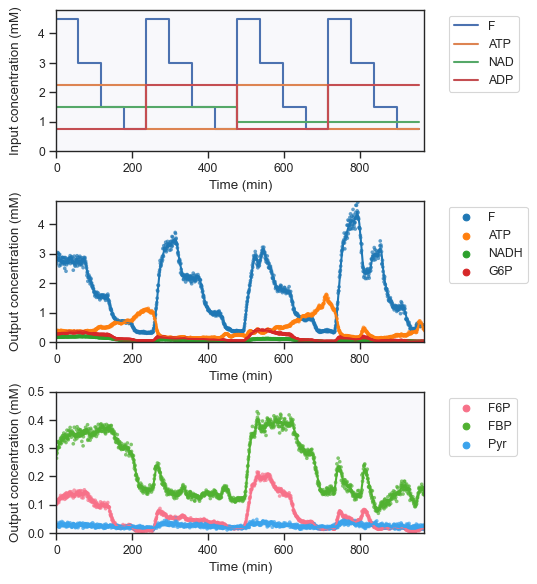

In [6]:
quantif_df1 = pd.DataFrame()
quantif_df2 = pd.DataFrame()

quantif_df1.index = sumdf.index
quantif_df2.index = sumdf.index

quantif_df1['F'] = (sumdf['L_F'] / sumdf['F'])*(F_concentration / sumdf["Flow ratio"])
quantif_df1['ATP'] = (sumdf['ATP_2+'] / sumdf['L_ATP_2+'])*(ATP_concentration / sumdf["Flow ratio"])
quantif_df1['NADH'] = (sumdf['NADH'] - NAD_2_13C_isotope*sumdf['NAD']) / 0.00302201 #Value determined in SNMS32
quantif_df1['G6P'] = (sumdf['L_G6P'] / sumdf['G6P'])*(G6P_concentration / sumdf["Flow ratio"])
quantif_df2['F6P'] = ((sumdf['L_F6P'] - (FBPtoF6P*sumdf['L_FBP'])) / (sumdf['F6P'] - (FBPtoF6P*sumdf['FBP'])))*(F6P_concentration / sumdf["Flow ratio"]) #With FBP to F6P correction
quantif_df2['FBP'] = (sumdf['L_FBP'] / sumdf['FBP'])*(FBP_concentration / sumdf["Flow ratio"])
quantif_df2['Pyr'] = (sumdf['L_Pyr'] / sumdf['13C_Pyr'])*(Pyr_concentration / sumdf["Flow ratio"])
quantif_df1.replace([np.inf, -np.inf], 0, inplace=True) #Replace infinity values by 0
quantif_df2.replace([np.inf, -np.inf], 0, inplace=True) #Replace infinity values by 0

quantif_df1.index = quantif_df1.index / 60 #s to min
quantif_df1.index = quantif_df1.index - 60 #removing the first 60 minutes of equilibration
quantif_df2.index = quantif_df2.index / 60 #s to min
quantif_df2.index = quantif_df2.index - 60 #removing the first 60 minutes of equilibration

rolled_df1 = quantif_df1.rolling(10, center=True).mean()
rolled_df2 = quantif_df2.rolling(10, center=True).mean()

fig, ax = plt.subplots(3,1)

sns.lineplot(data = df_inputgraph, x="time", y="F", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="F", palette="tab10")
sns.lineplot(data = df_inputgraph, x="time", y="ATP", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="ATP", palette="tab10")
sns.lineplot(data = df_inputgraph, x="time", y="NAD", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="NAD", palette="tab10")
sns.lineplot(data = df_inputgraph, x="time", y="ADP", drawstyle='steps', alpha=1, ax=ax[0], linewidth=1.5, label="ADP", palette="tab10")

sns.scatterplot(quantif_df1, alpha=0.7, ax=ax[1],  markers=["o"], s=7, palette="tab10", linewidth=0)
sns.lineplot(rolled_df1, dashes=False, alpha=1, ax=ax[1], linewidth=1.5, legend=None, palette="tab10")
sns.scatterplot(quantif_df2, alpha=0.7, ax=ax[2],  markers=["o"], s=7, palette="husl", linewidth=0)
sns.lineplot(rolled_df2, dashes=False, alpha=1, ax=ax[2], linewidth=1.5, legend=None, palette="husl")

ax[0].set_xlim(0,970)
ax[0].set_ylim(0,4.8)
ax[1].set_xlim(0,970)
ax[1].set_ylim(0,4.8)
ax[2].set_xlim(0,970)
ax[2].set_ylim(0,0.5)
ax[0].set_xlabel("Time (min)")
ax[0].set_ylabel("Input concentration (mM)")
ax[1].set_xlabel("Time (min)")
ax[1].set_ylabel("Output concentration (mM)")
ax[2].set_xlabel("Time (min)")
ax[2].set_ylabel("Output concentration (mM)")

fig.align_ylabels(ax[:])
ax[0].set_facecolor('#F8F8FB')
ax[1].set_facecolor('#F8F8FB')
ax[2].set_facecolor('#F8F8FB')

ax[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
ax[2].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.subplots_adjust(left=None, bottom=None, right=0.7, top=1.2, wspace=None, hspace=0.35)
#plt.savefig('SNMS34.png', format='png', bbox_inches='tight', dpi=600)

### Getting the intensities of the metabolites we do not quantify
#### Making Figure S4

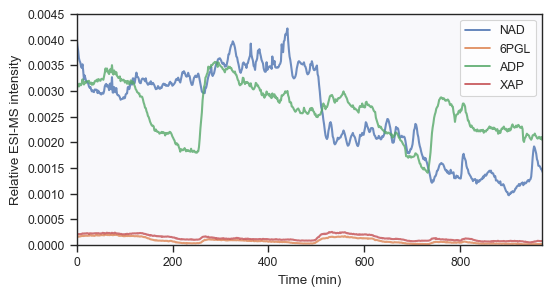

In [7]:
intensity_df = pd.DataFrame()
intensity_df.index = sumdf.index
intensity_df["NAD"] = sumdf["NAD"]
intensity_df["6PGL"] = sumdf["6PGL"]
intensity_df["ADP"] = sumdf["ADP"]
intensity_df["XAP"] = sumdf["L_GAP_DHAP"]

#binning
df_Time_Samp = intensity_df.groupby(intensity_df.index // TIMEBIN).min()
df_intensity_Samp =  intensity_df.groupby(intensity_df.index // TIMEBIN).mean()

df_intensity_Samp.index = (df_Time_Samp.index * TIMEBIN /60) - 60 #in minutes, minus the first 60 minutes of equilibration

fig, ax = plt.subplots(figsize=(6, 3))
sns.lineplot(df_intensity_Samp, dashes=False, alpha=0.8, linewidth=1.5)
ax.set_xlim(0,970)
ax.set_ylim(0,0.0045)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Relative ESI-MS intensity")
ax.set_facecolor('#F8F8FB')
#plt.savefig('SNMS34_SI_intensities.png', format='png', bbox_inches='tight', dpi=600)

### Estimation of the "observable conversion" of substrate in observable metabolites
#### Making Figure S6b

C:\Users\qduez\AppData\Local\Temp\ipykernel_15700\2867579776.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(conversion_all, alpha=0.8, s=7, palette="tab10", linewidth=0, label="F", color="purple")


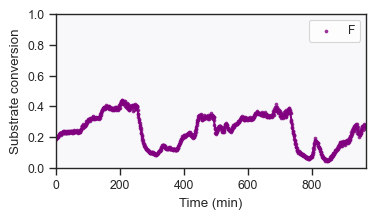

In [8]:
conversion_all = (quantif_df1['G6P'] + quantif_df2['F6P'] + quantif_df2['FBP'] + quantif_df2['Pyr']) / (quantif_df1['G6P'] + quantif_df2['F6P'] + quantif_df2['FBP'] + quantif_df2['Pyr'] + quantif_df1['F'])
rollingconv_all = conversion_all.rolling(10, center=True).mean()

fig, ax = plt.subplots(figsize=(4, 2))
sns.scatterplot(conversion_all, alpha=0.8, s=7, palette="tab10", linewidth=0, label="F", color="purple")
sns.lineplot(rollingconv_all, linewidth=1.5, color="purple")

ax.set_xlim(0,970)
ax.set_ylim(0,1)
ax.set_xlabel("Time (min)")
ax.set_ylabel("Substrate conversion")
ax.set_facecolor('#F8F8FB')
#plt.savefig('SNMS34_SI_conversion.png', format='png', bbox_inches='tight', dpi=600)

### Summing the concentration of observable metabolites
#### Making Figure S7b

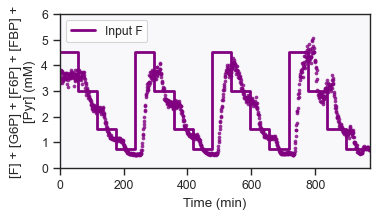

In [9]:
totaldf = pd.DataFrame()
totaldf = (quantif_df1['F'] + quantif_df1['G6P'] + quantif_df2['F6P'] + quantif_df2['FBP'] + quantif_df2['Pyr'] )

fig, ax = plt.subplots(figsize=(4, 2))
sns.scatterplot(totaldf, alpha=0.8, legend=None, s=7, color="purple", linewidth=0)
sns.lineplot(data = df_inputgraph, x="time", y="F", drawstyle='steps', alpha=1, linewidth=2, label='Input F', color="purple")
ax.set_xlim(0,970)
ax.set_ylim(0,6)
ax.set_xlabel("Time (min)")
ax.set_ylabel("[F] + [G6P] + [F6P] + [FBP] + [Pyr] (mM)", wrap=True)
ax.set_facecolor('#F8F8FB')
#plt.savefig('SNMS34_SI_summedconc.png', format='png', bbox_inches='tight', dpi=600)

### Estimation of the observation limit
#### Making Figure S5b
##### The observation limit is determined as the concentration associated with the background noise at the m/z of metabolites we do not observe (3PG and PEP for instance)

LOD is 0.020895081717637855 mM


C:\Users\qduez\AppData\Local\Temp\ipykernel_15700\3117148497.py:15: UserWarning: 
The markers list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(quantif_df3, alpha=0.5, s=7, markers=['o'], linewidth=0)


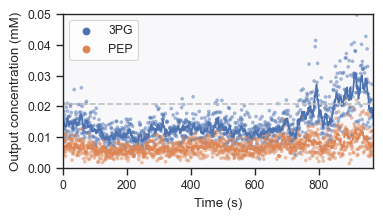

In [10]:
quantif_df3 = pd.DataFrame()
quantif_df3.index = sumdf.index
quantif_df3['3PG'] = (sumdf['L_3PG'] / sumdf['3PG'])*(PG_concentration/ sumdf["Flow ratio"])
quantif_df3['PEP'] = (sumdf['L_PEP'] / sumdf['PEP'])*(PEP_concentration/ sumdf["Flow ratio"])
LOD_3PG = quantif_df3['3PG'].mean() + 1.645*quantif_df3['3PG'].std()
LOD_PEP = quantif_df3['PEP'].mean() + 1.645*quantif_df3['PEP'].std()
LOD = (LOD_PEP + LOD_3PG)/2
print("LOD is " + str(LOD) + " mM")

quantif_df3.index = (quantif_df3.index/60)-60 #in minutes, minus the first 60 minutes of equilibration

rolled_df3 = quantif_df3.rolling(10, center=True).mean()

fig, ax = plt.subplots(figsize=(4, 2))
sns.scatterplot(quantif_df3, alpha=0.5, s=7, markers=['o'], linewidth=0)
sns.lineplot(rolled_df3, legend=None)

ax.set_xlim(0,970)
ax.set_ylim(0,0.05)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Output concentration (mM)")
ax.axhline(LOD, c='silver', linestyle="--")
ax.set_facecolor('#F8F8FB')
#plt.savefig('SNMS34_SI_LOD.png', format='png', bbox_inches='tight', dpi=600)